# Low-rank nonnegative tensor approximation via alternating projections and sketching

In [7]:
##
%reload_ext autoreload
%autoreload 2
##
import sys
sys.path.append('./src')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as spio
from time import time

from truncatedSvd import TruncatedSvd
from experiment import Experiment

In [8]:
%%bash
lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          4
On-line CPU(s) list:             0-3
Vendor ID:                       GenuineIntel
Model name:                      Intel(R) Core(TM) i3-8130U CPU @ 2.20GHz
CPU family:                      6
Model:                           142
Thread(s) per core:              2
Core(s) per socket:              2
Socket(s):                       1
Stepping:                        10
BogoMIPS:                        4415.99
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology cpuid pni pclmulqdq vmx ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single 

## 1. Multidimensional Gaussian mixture

In [43]:
t0 = time()

N = 128
N1 = N
N2 = N
N3 = N
A = np.zeros([N1, N2,N3])
cov_mat = np.random.uniform(0, 1, [3,3])
cov_mat = cov_mat @ cov_mat.T
cov_mat = cov_mat / np.linalg.norm(cov_mat)
cov_mat2 = np.random.uniform(0, 1, [3,3])
cov_mat2 = cov_mat2 @ cov_mat2.T
cov_mat2 = cov_mat2 / np.linalg.norm(cov_mat2)

cov_mat3 = np.random.uniform(0, 1, [3,3])
cov_mat3 = cov_mat3 @ cov_mat3.T
cov_mat3 = cov_mat3 / np.linalg.norm(cov_mat3)

h = 4. / N
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            point = np.array([i*h, j*h, k*h])
            A[i,j,k] = np.exp(-point @ cov_mat  @ point) +\
                       np.exp(-point @ cov_mat2 @ point) +\
                       np.exp(-point @ cov_mat3 @ point)
            
print('%d s.' % (time() - t0))

50 s.


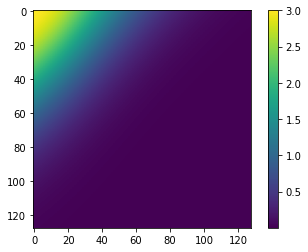

In [44]:
plt.imshow(A[:, :, 0])
_ = plt.colorbar()

In [98]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1,  k=15))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0,  k=16))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=10, l=25))
# nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6,  l=11))

nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1, k=14))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0, k=14))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=29))
# nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6, l=10))

nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))


tuckerRank = (5, 5, 5)
ttRank = (5, 5)
itersNum = 100

ex = Experiment(tensor=A,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [100]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      0.71210
negative elements (fro)      |     0.000321
negative elements (che)      |     0.000003
negative elements (%)        |   4.39729691
relative error (fro)         | 0.0000264616
relative error (che)         | 0.0001496237
SNR (dB)                     | 45.773834482
r2_score                     | 0.9999999993
compression                  |       468.11
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      0.72164
negative elements (fro)      |     0.000720
negative elements (che)      |     0.000010
negative elements (%)        |   2.54888535
relative error (fro)         | 0.0000712171
relative error (che)         | 0.0003009843
SNR (dB)                     | 41.474157621
r2_score                     | 0.9999999946
compression                  |      1025.50
-------------------------------------------


In [58]:
ex.time(itersNum, nttsvd=True, nsthosvd=False, nlrt=False)

NTTSVD
------------------------------------
SVD$_r$                 |  45.93 s.
HMT(1,14), Rad          |  11.42 s.
HMT(0,14), Rad          |   8.09 s.
Tropp(7,29), Rad        |   6.36 s.
------------------------------------


In [59]:
ex.time(itersNum, nttsvd=False, nsthosvd=True, nlrt=False)

NSTHOSVD
------------------------------------
SVD$_r$                 |  45.62 s.
HMT(1,15), Rad          |  12.18 s.
HMT(0,16), Rad          |   8.53 s.
Tropp(10,25), Rad       |   7.54 s.
------------------------------------


In [181]:
ex.time(itersNum, nttsvd=False, nsthosvd=False, nlrt=True)

NLRT
------------------------------------
SVD$_r$                 | 113.34 s.
------------------------------------


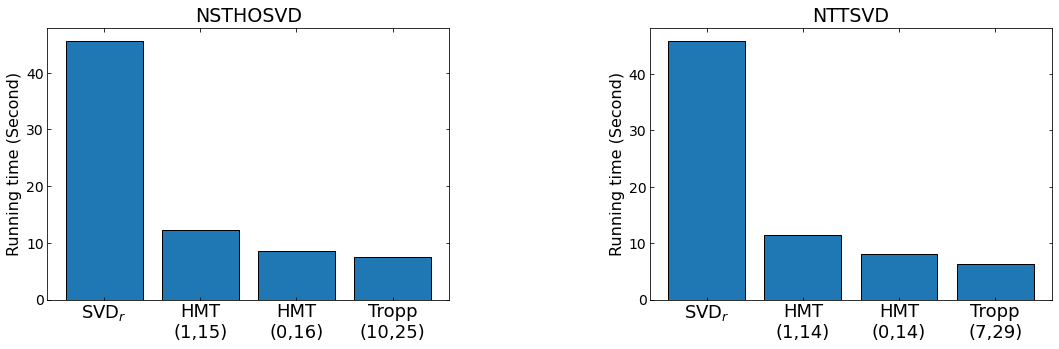

In [60]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=18,
                          yticksize=14,
                          wspace=0.5,
                          paramsNewLine=True)

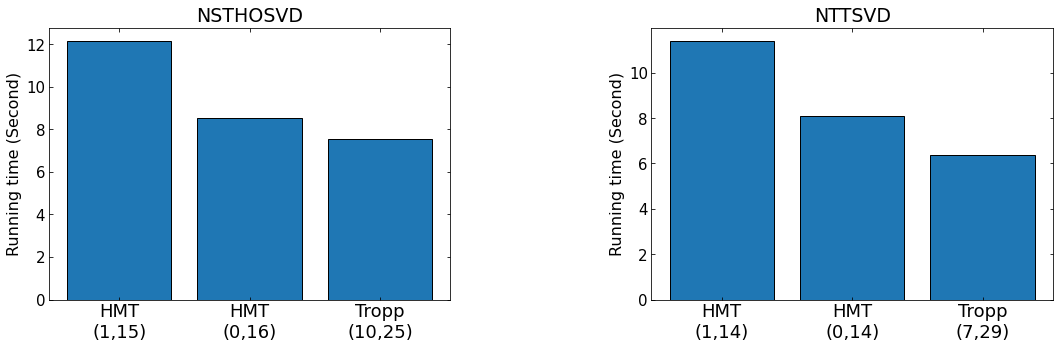

In [61]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=18,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

In [47]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  |  61.46 s.
HMT(1,14), Rad           |  10.63 s.
HMT(0,14), Rad           |   8.80 s.
Tropp(7,29), Rad         |  11.82 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  |  48.16 s.
HMT(1,15), Rad           |   9.37 s.
HMT(0,16), Rad           |   8.21 s.
Tropp(10,25), Rad        |   7.78 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 167.43 s.
------------------------------------


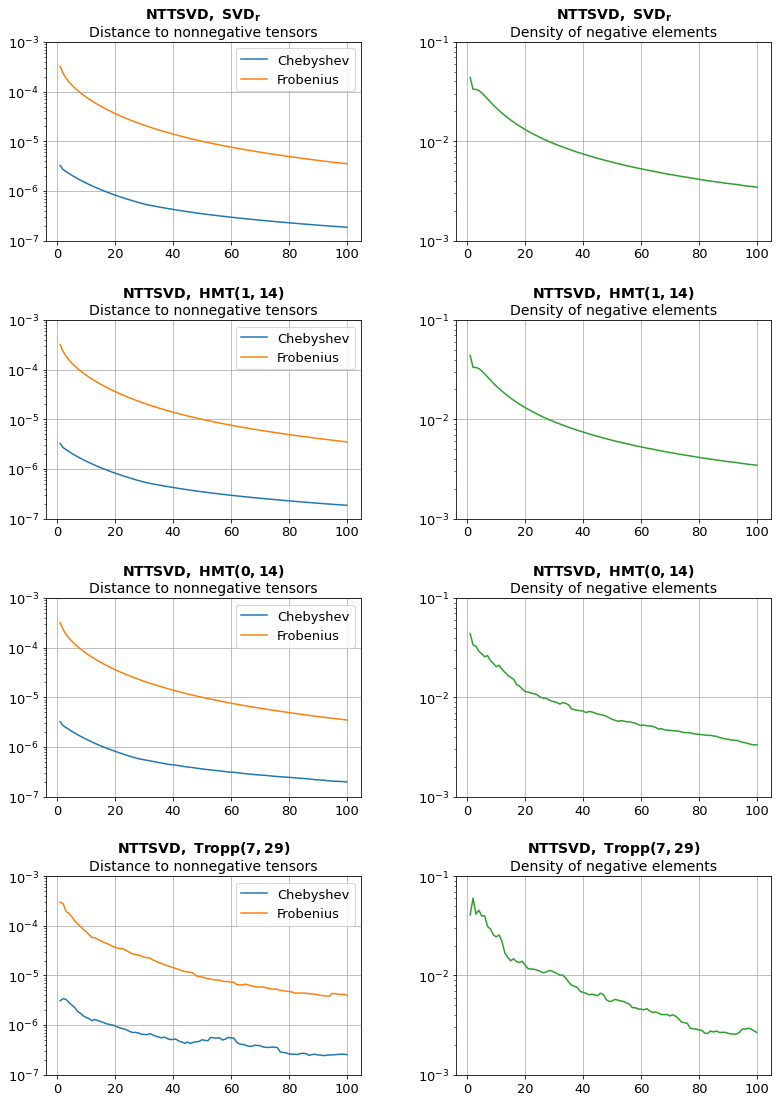

In [80]:
fig, ax = ex.plotConvergence2(nsthosvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(3, 8)],
                              yticks2=[10**(-x) for x in range(1, 4)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')z

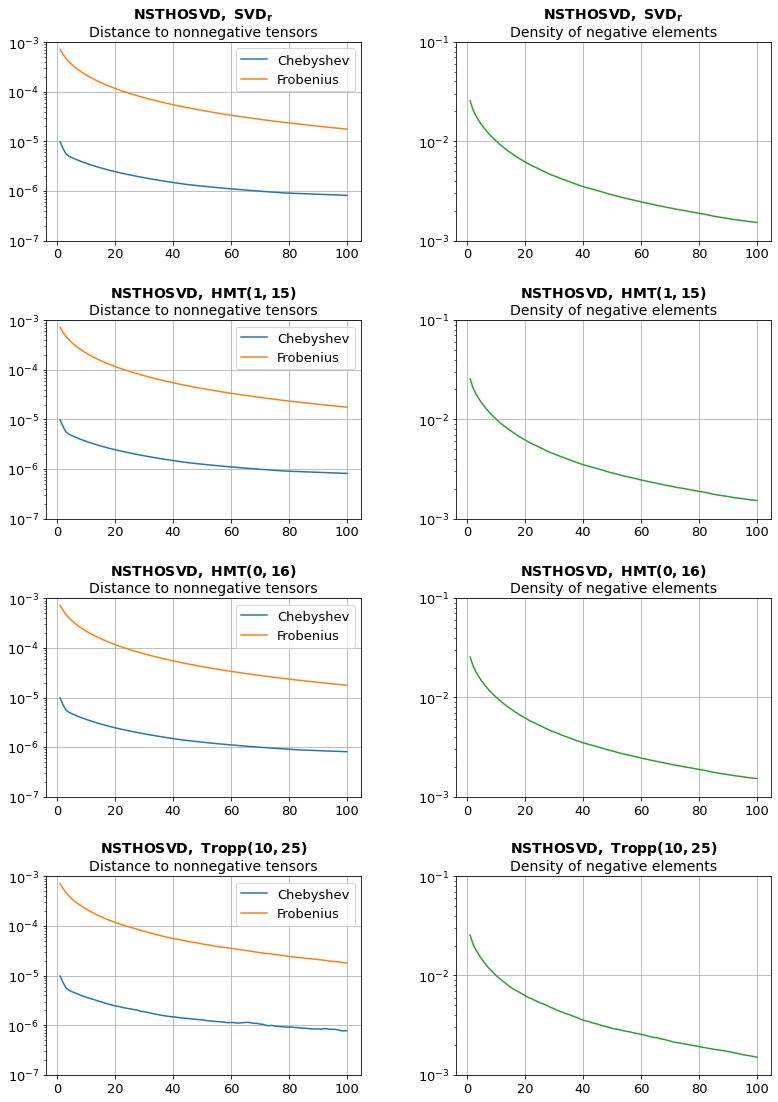

In [81]:
fig, ax = ex.plotConvergence2(nttsvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(3, 8)],
                              yticks2=[10**(-x) for x in range(1, 4)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')

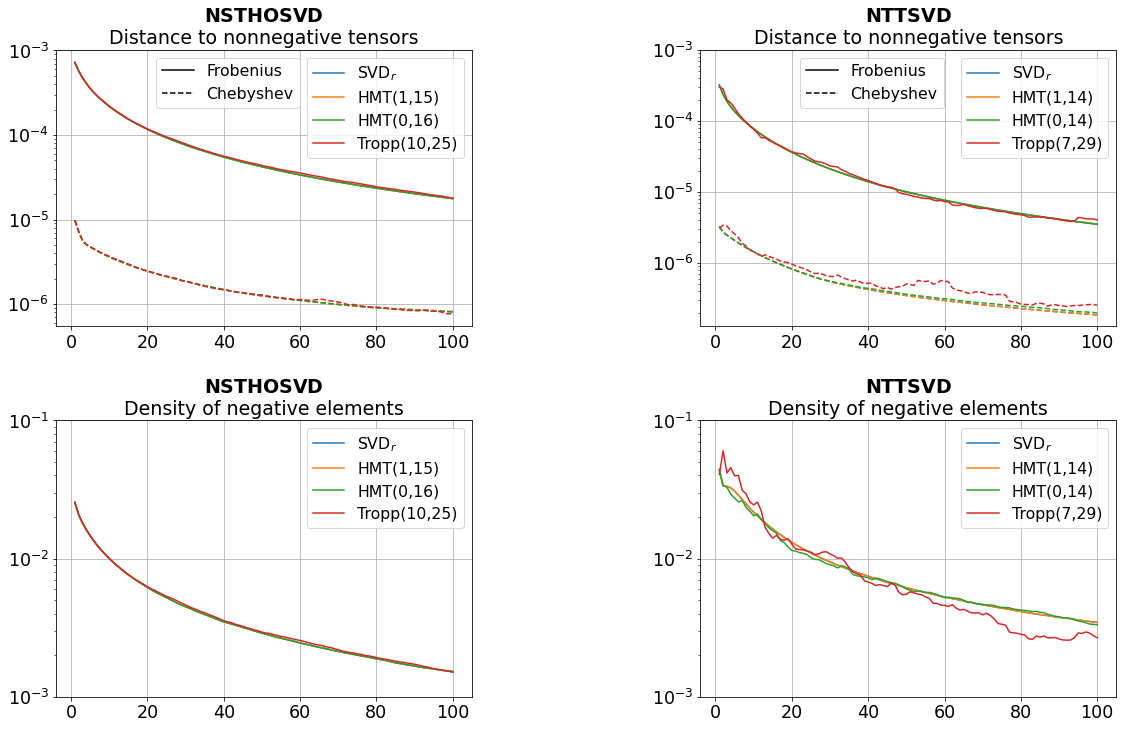

In [71]:
fig, ax = ex.plotConvergence3(figsize=(19, 11.9),
                              yticks=[10**(-x) for x in range(3, 7)],
                              yticks2=[10**(-x) for x in range(1, 4)],
                              wspace=0.55,
                              hspace=0.34,
                              titlesize=19,
                              ticksize=17.5,
                              legendsize=15.74,
                              legendloc='upper right',
                              legend2loc=(0.24, 0.79))

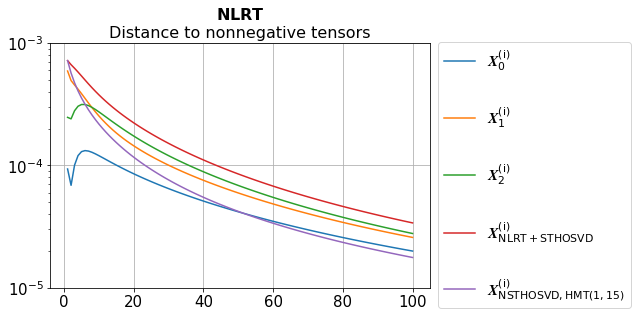

In [58]:
fig, ax = ex.plotConvergence(nttsvd=False,
                             nsthosvd=False,
                             nlrt=True,
                             figsize=(6.8, 4.5),
                             titlesize=16,
                             ticksize=15,
                             legendsize=15.5,
                             bbox_to_anchor=(1, 1.037), # bbox_to_anchor=(1, 1.038),
                             labelspacing=2.08, # labelspacing=1.74,
                             yticks=[10**(-x) for x in range(3, 6)])

In [51]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) |      SNR | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000026569333908619 | 0.000150101221829827 | 45.75619 | 1.000000 |
| HMT(1,14), Rad           | 0.000026569333908618 | 0.000150101224337303 | 45.75619 | 1.000000 |
| HMT(0,14), Rad           | 0.000026570308969123 | 0.000150559147587141 | 45.75603 | 1.000000 |
| Tropp(7,29), Rad         | 0.000026961018433742 | 0.000145999100968464 | 45.69264 | 1.000000 |
------------------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) |      SNR | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000071486062971910 | 0.000304188871645887 | 41.45779 | 1.000000 |
| HMT(1,15), Rad           | 0

In [52]:
ex.printNegativePart()

| NTTSVD                   | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000003516665814256893 | 0.000000185840731707084 | 0.345611572265625000000 |
| HMT(1,14)                | 0.000003516665816823185 | 0.000000185840731841159 | 0.345611572265625000000 |
| HMT(0,14)                | 0.000003507032664119834 | 0.000000198183373054562 | 0.332164764404296875000 |
| Tropp(7,29)              | 0.000004020878834274572 | 0.000000254613886839934 | 0.267362594604492187500 |
----------------------------------------------------------------------------------------------------------
| NSTHOSVD                 | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000017

# 2. Function Based Tensors

## 2.1 Hilbert Tensor

An Nth order Hilbert tensor is defined as follows
$$A(i_1, \dots, i_N) = \frac{1}{i_1 + \dots + i_N - N + 1}$$

In [82]:
shape = [128, 128, 128]

a = np.empty(shape=shape)

m, n, l = a.shape
for i in range(m):
    for j in range(n):
        for k in range(l):
            a[i, j, k] = 1 / ((i+1) + (j+1) + (k+1) - 3 + 1)

In [101]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=11, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=15, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=14, distr='rademacher'))
# nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6, l=13, distr='rademacher'))

nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=12, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=15, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=14, distr='rademacher'))
# nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=4, l=6, distr='rademacher'))

nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))

tuckerRank = (3, 2, 4)
ttRank = (3, 2)
itersNum = 250

ex = Experiment(tensor=a,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [102]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      0.74612
negative elements (fro)      |     0.097679
negative elements (che)      |     0.016310
negative elements (%)        |   0.00634193
relative error (fro)         | 0.0771893852
relative error (che)         | 0.3671764120
SNR (dB)                     | 11.124424184
r2_score                     | 0.9798626863
compression                  |      1489.45
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      0.55460
negative elements (fro)      |     0.097543
negative elements (che)      |     0.016291
negative elements (%)        |   0.00634193
relative error (fro)         | 0.0771894871
relative error (che)         | 0.3671781751
SNR (dB)                     | 11.124418451
r2_score                     | 0.9798626331
compression                  |      1783.29
-------------------------------------------


In [85]:
ex.time(itersNum, nttsvd=False, nsthosvd=True, nlrt=False)

NSTHOSVD
------------------------------------
SVD$_r$                 | 119.24 s.
HMT(1,11), Rad          |  16.03 s.
HMT(0,15), Rad          |  14.33 s.
Tropp(7,14), Rad        |  12.98 s.
------------------------------------


In [95]:
ex.time(itersNum, nttsvd=True, nsthosvd=False, nlrt=False)

NTTSVD
------------------------------------
SVD$_r$                 | 133.11 s.
HMT(1,12), Rad          |  16.43 s.
HMT(0,15), Rad          |  13.11 s.
Tropp(7,14), Rad        |  11.45 s.
------------------------------------


In [87]:
ex.time(itersNum, nttsvd=False, nsthosvd=False, nlrt=True)

NLRT
------------------------------------
SVD$_r$                 | 340.40 s.
------------------------------------


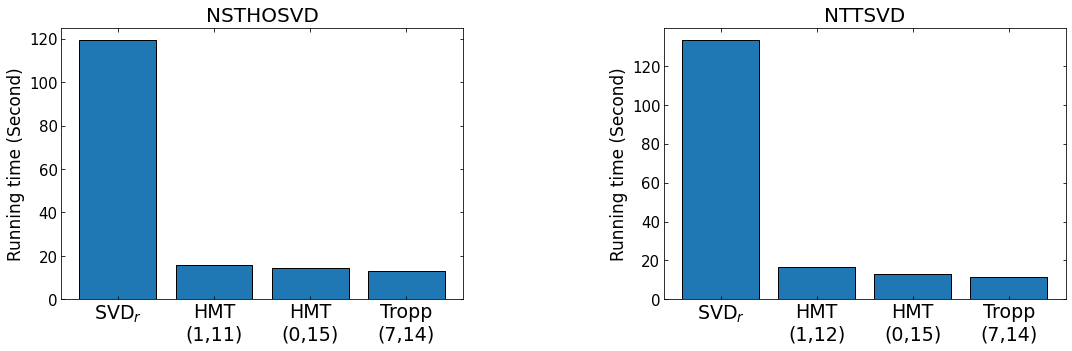

In [96]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True)

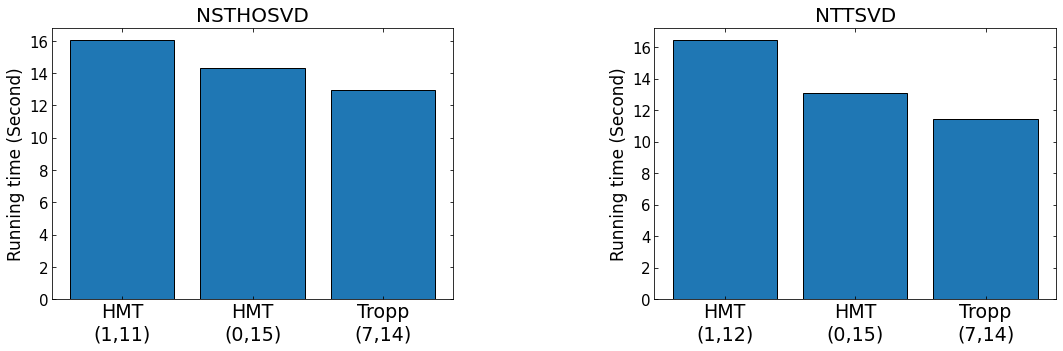

In [97]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

In [90]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  | 133.48 s.
HMT(1,12), Rad           |  21.93 s.
HMT(0,15), Rad           |  22.25 s.
Tropp(7,14), Rad         |  20.43 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  | 116.72 s.
HMT(1,11), Rad           |  23.30 s.
HMT(0,15), Rad           |  22.00 s.
Tropp(7,14), Rad         |  19.46 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 497.19 s.
------------------------------------


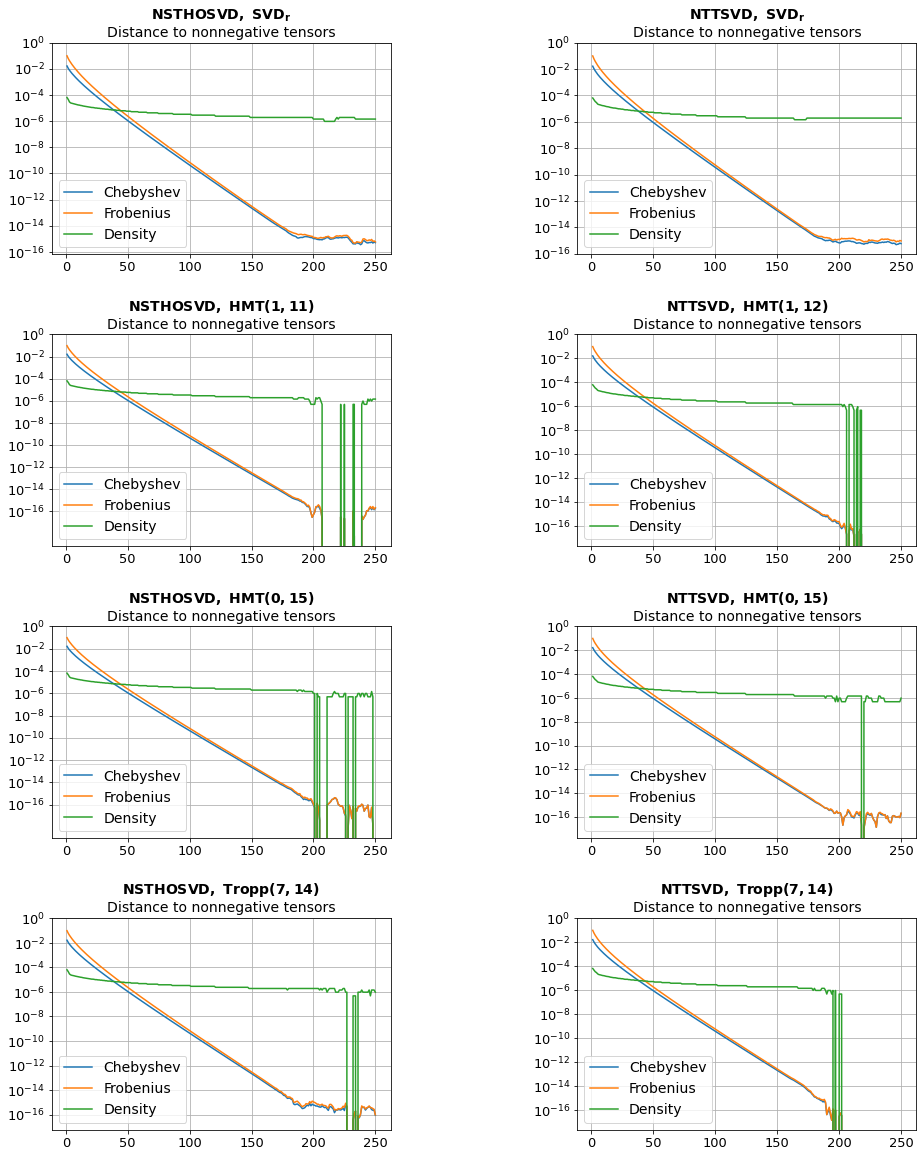

In [91]:
fig, ax = ex.plotConvergence(nlrt=False,
                             figsize=(15.5, 20),
                             yticks=[10**(-x) for x in range(0, 17, 2)],
                             hspace=0.38, wspace=0.55,
                             titlesize=14,
                             ticksize=13,
                             legendsize=14,
                             legendloc='lower left')

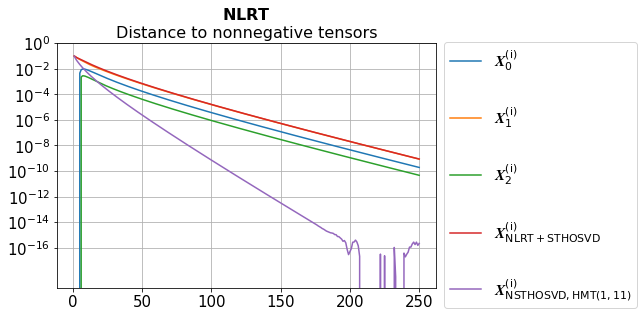

In [92]:
fig, ax = ex.plotConvergence(nttsvd=False,
                             nsthosvd=False,
                             nlrt=True,
                             figsize=(6.8, 4.5),
                             titlesize=16,
                             ticksize=15,
                             legendsize=15.5,
                             bbox_to_anchor=(1, 1.037),
                             labelspacing=2.08,
                             yticks=[10**(-x) for x in range(0, 17, 2)])

In [93]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) |      SNR | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.078820710858905962 | 0.394445165838060552 | 11.03360 | 0.979003 |
| HMT(1,12), Rad           | 0.078820710858910181 | 0.394445165838175904 | 11.03360 | 0.979003 |
| HMT(0,15), Rad           | 0.078820710858909709 | 0.394445165838100853 | 11.03360 | 0.979003 |
| Tropp(7,14), Rad         | 0.078813960636483230 | 0.396435641720366272 | 11.03397 | 0.979006 |
------------------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) |      SNR | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.078947343689500044 | 0.395001547796862029 | 11.02662 | 0.978935 |
| HMT(1,11), Rad           | 0

In [94]:
ex.printNegativePart()

| NTTSVD                   | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000000000000000935290 | 0.000000000000000582867 | 0.000190734863281250000 |
| HMT(1,12)                | 0.000000000000000000000 | 0.000000000000000000000 | 0.000000000000000000000 |
| HMT(0,15)                | 0.000000000000000213377 | 0.000000000000000201228 | 0.000095367431640625000 |
| Tropp(7,14)              | 0.000000000000000000000 | 0.000000000000000000000 | 0.000000000000000000000 |
----------------------------------------------------------------------------------------------------------
| NSTHOSVD                 | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000000

## 3. Hyperspectral Images (HSIs)

### 3.1. Washington, DC
https://github.com/JakobSig/HSI2RGB/blob/master/washington_hsi.mat

shape: (191, 307, 307)
min_elem: 0.0
max_elem: 1.0


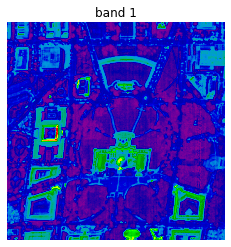

In [106]:
HSI_path = 'data/washington_hsi.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['Y']
HSI_data = np.moveaxis(HSI_data, -1, 0)
img = HSI_data / HSI_data.max()

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 1
plt.imshow(img[band], cmap='nipy_spectral')
plt.title(f'band {band}')
plt.axis('off')
plt.show()

In [107]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1,  k=75, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0,  k=75, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=60, l=150, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=50, l=150, distr='rademacher'))


nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=75, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=75, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=60, l=150, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=50, l=150, distr='rademacher'))

nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))


tuckerRank = [33, 40, 40]
ttRank = [33, 33]
itersNum = 100

ex = Experiment(tensor=img,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [18]:
hoRanks = [33, 40, 40]
ttRanks = [33, 33]
itersNum = 100

ex = Experiment(tensor=img, ttSvdrList=ttSvdrList, hoSvdrList=hoSvdrList)
ex.setRanks(hoRanks=hoRanks, ttRanks=ttRanks)

In [109]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      7.82008
negative elements (fro)      |     2.218145
negative elements (che)      |     0.068240
negative elements (%)        |   3.14982163
relative error (fro)         | 0.1814581084
relative error (che)         | 0.4532713527
SNR (dB)                     |  7.412236206
r2_score                     | 0.9419990389
compression                  |        51.32
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      3.88063
negative elements (fro)      |     2.081441
negative elements (che)      |     0.070907
negative elements (%)        |   2.89294388
relative error (fro)         | 0.1845035115
relative error (che)         | 0.4622325103
SNR (dB)                     |  7.339953638
r2_score                     | 0.9400358470
compression                  |       215.17
-------------------------------------------


In [110]:
ex.time(itersNum)

NTTSVD
------------------------------------
SVD$_r$                 | 341.25 s.
HMT(1,75), Rad          | 236.89 s.
HMT(0,75), Rad          | 173.53 s.
Tropp(60,150), Rad      | 151.50 s.
Tropp(50,150), Rad      | 102.17 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                 | 440.02 s.
HMT(1,75), Rad          | 296.75 s.
HMT(0,75), Rad          | 268.61 s.
Tropp(60,150), Rad      | 225.04 s.
Tropp(50,150), Rad      | 131.63 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                 | 1874.12 s.
------------------------------------


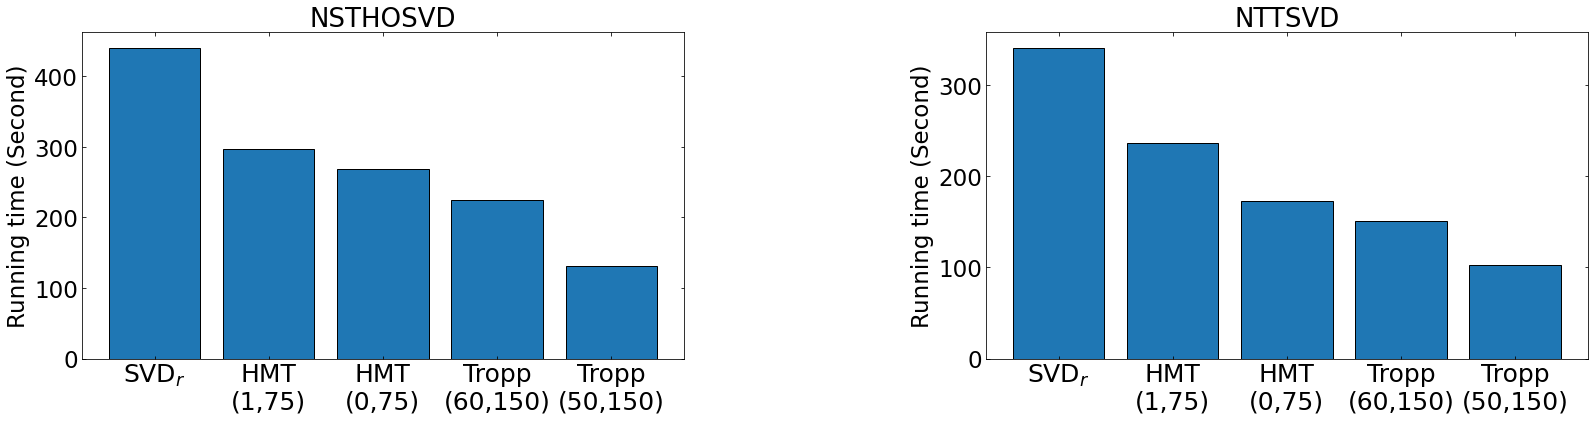

In [196]:
fig, ax = ex.plotRuntimes(figsize=(27, 6),
                          titlesize=26,
                          ylabelsize=23,
                          xticksize=25,
                          yticksize=23,
                          wspace=0.5,
                          paramsNewLine=True)

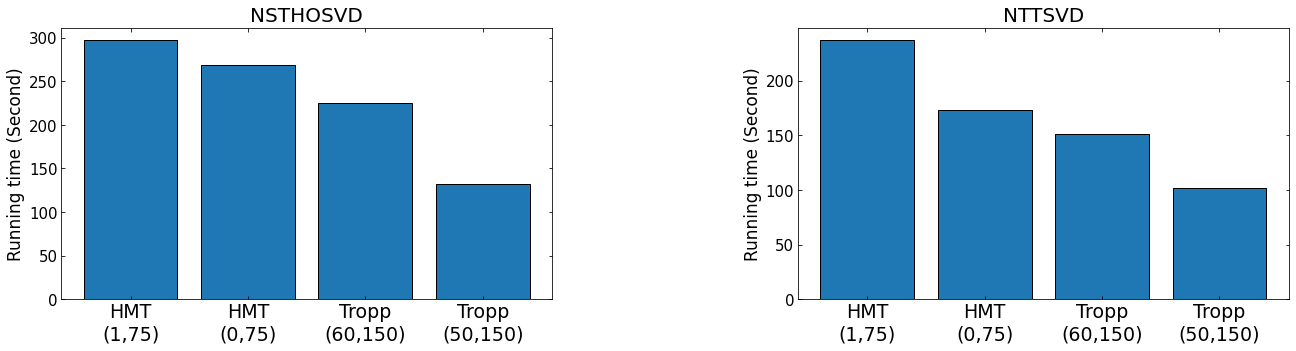

In [180]:
fig, ax = ex.plotRuntimes(figsize=(22, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

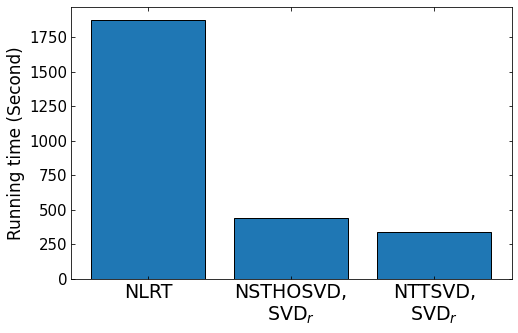

In [171]:
fig, ax = ex.plotRuntimes2(figsize=(7.9, 5),
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          paramsNewLine=True,
                          exclude=[0])

In [113]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  | 759.73 s.
HMT(1,75), Rad           | 544.17 s.
HMT(0,75), Rad           | 325.81 s.
Tropp(60,150), Rad       | 287.67 s.
Tropp(50,150), Rad       | 241.36 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  | 417.47 s.
HMT(1,75), Rad           | 233.16 s.
HMT(0,75), Rad           | 170.04 s.
Tropp(60,150), Rad       | 112.00 s.
Tropp(50,150), Rad       |  92.73 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 1224.10 s.
------------------------------------


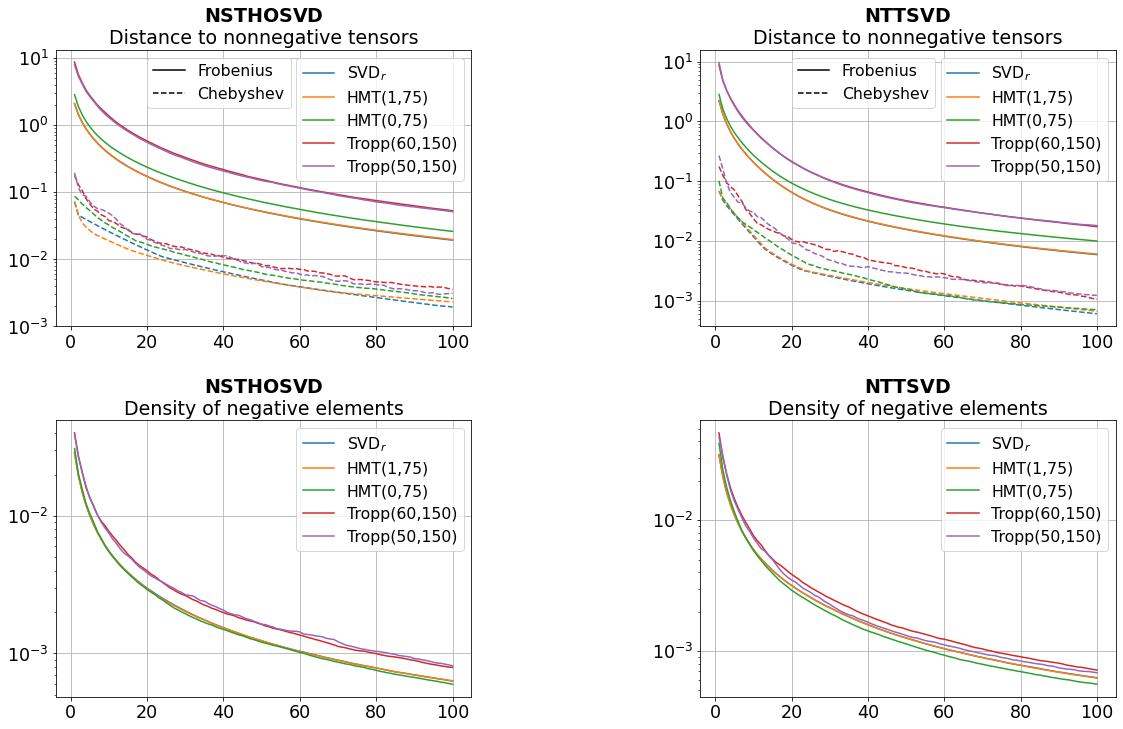

In [272]:
fig, ax = ex.plotConvergence3(figsize=(19, 11.9),
                              yticks=[10**(-x) for x in range(-1, 4)],
                              wspace=0.55,
                              hspace=0.34,
                              titlesize=19,
                              ticksize=17.5,
                              legendsize=15.74,
                              legendloc='upper right',
                              legend2loc=(0.22, 0.79))

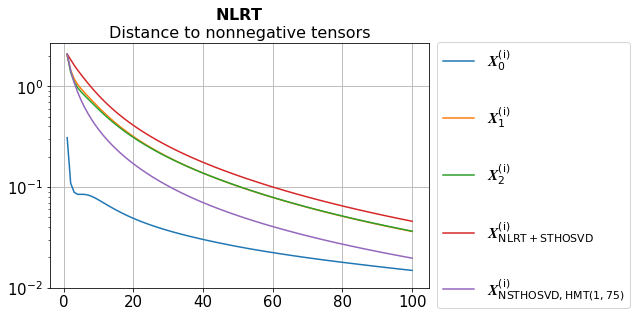

In [133]:
fig, ax = ex.plotConvergence(nttsvd=False,
                             nsthosvd=False,
                             nlrt=True,
                             figsize=(6.8, 4.5),
                             titlesize=16,
                             ticksize=15,
                             legendsize=15.5,
                             bbox_to_anchor=(1, 1.037), # bbox_to_anchor=(1, 1.038),
                             labelspacing=2.08, # labelspacing=1.74,
                             yticks=[10**(-x) for x in range(0, 3)])

In [115]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.181579502297610607 | 0.453385570169014596 |  7.40933 | 0.941921 |
| HMT(1,75), Rad           | 0.181885645328886181 | 0.453454792901344494 |  7.40202 | 0.941725 |
| HMT(0,75), Rad           | 0.207726777844755156 | 0.457268780431863475 |  6.82508 | 0.923991 |
| Tropp(60,150), Rad       | 0.261491567441592854 | 0.471493695264617096 |  5.82542 | 0.879552 |
| Tropp(50,150), Rad       | 0.267232542379661153 | 0.460351492303374632 |  5.73111 | 0.874206 |
------------------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0

In [116]:
ex.printNegativePart()

| NTTSVD                   | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.005922567015812484244 | 0.000607109577990490312 | 0.062494587274357742135 |
| HMT(1,75)                | 0.006050705462389094000 | 0.000670740693662142447 | 0.062100176990226234330 |
| HMT(0,75)                | 0.009992317612014099681 | 0.000710363085542753316 | 0.055767392146424656085 |
| Tropp(60,150)            | 0.017372580036018155786 | 0.001061322447043671138 | 0.071521583213987188765 |
| Tropp(50,150)            | 0.018101852643791088021 | 0.001230903397752819168 | 0.068227424080325491107 |
----------------------------------------------------------------------------------------------------------
| NSTHOSVD                 | negative elements (fro) | negative elements (che) |   negative elements (%) |
-------------------------------------

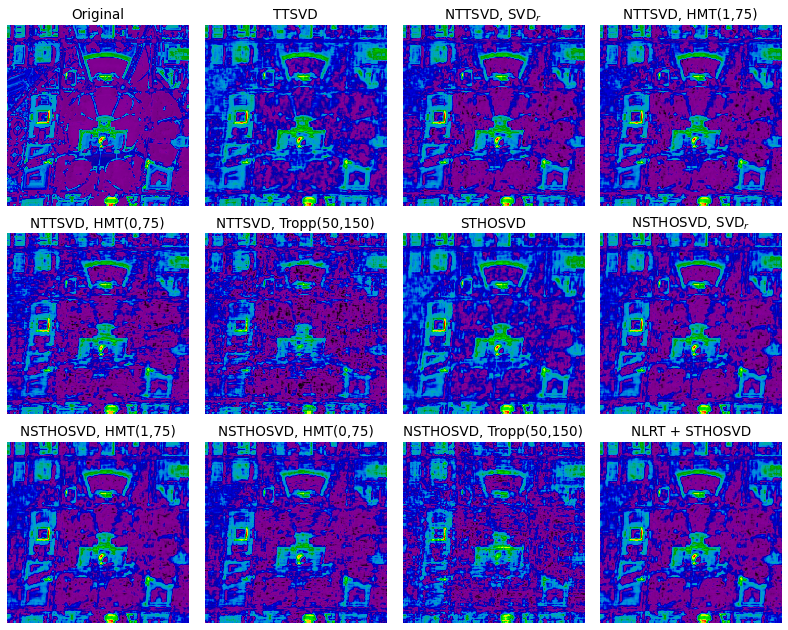

In [157]:
fig, ax = ex.showApproximations(band=50,
                                figsize=(14, 11),
                                ncols=4,
                                wspace=0.05,
                                hspace=0.15,
                                titlesize=13.5,
                                cmap='nipy_spectral',
                                exclude=[5, 11])

### 1.2. WHU-Hi-LongKou
http://rsidea.whu.edu.cn/resource_WHUHi_sharing.htm

shape: (270, 550, 400)
min_elem: 0.0
max_elem: 28.1


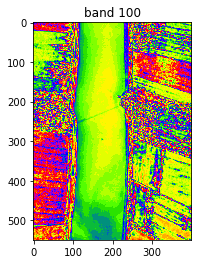

In [240]:
# original image

HSI_path = 'data/WHU_Hi_LongKou.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['WHU_Hi_LongKou']
HSI_data = np.moveaxis(HSI_data, -1, 0)

img = HSI_data

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 100
plt.imshow(img[band], cmap='prism')
plt.title(f'band {band}')
plt.show()

shape: (270, 200, 200)
min_elem: 0.0
max_elem: 1.0


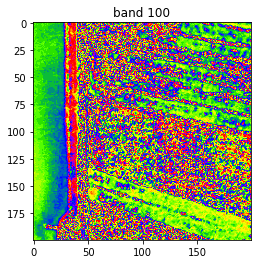

In [241]:
# subimage

HSI_path = 'data/WHU_Hi_LongKou.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['WHU_Hi_LongKou']
HSI_data = np.moveaxis(HSI_data, -1, 0)

img = HSI_data[:, 0:0+200, 200:200+200]
img /= img.max() #

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 100
plt.imshow(img[band], cmap='prism')
plt.title(f'band {band}')
plt.show()

In [242]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=34, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=34, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=19, l=42, distr='rademacher'))


nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=34, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=34, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=19, l=42, distr='rademacher'))

nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))


tuckerRank = [17, 16, 17]
ttRank = [15, 15]
itersNum = 100

ex = Experiment(tensor=img,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [243]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      0.98587
negative elements (fro)      |     0.204293
negative elements (che)      |     0.032477
negative elements (%)        |   0.00439815
relative error (fro)         | 0.0824982598
relative error (che)         | 0.2826899290
SNR (dB)                     | 10.835552120
r2_score                     | 0.9843181597
compression                  |       207.49
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      1.33578
negative elements (fro)      |     0.030170
negative elements (che)      |     0.006397
negative elements (%)        |   0.00128704
relative error (fro)         | 0.0829690844
relative error (che)         | 0.2638227046
SNR (dB)                     | 10.810837026
r2_score                     | 0.9841386374
compression                  |       682.94
-------------------------------------------


In [27]:
ex.time(itersNum, nsthosvd=True, nttsvd=False, nlrt=False)

NSTHOSVD
------------------------------------
SVD$_r$                 |  77.87 s.
HMT(1,34), Rad          |  30.64 s.
HMT(0,34), Rad          |  21.78 s.
Tropp(19,42), Rad       |  17.82 s.
------------------------------------


In [28]:
ex.time(itersNum, nsthosvd=False, nttsvd=True, nlrt=False)

NTTSVD
------------------------------------
SVD$_r$                 |  67.37 s.
HMT(1,34), Rad          |  40.93 s.
HMT(0,34), Rad          |  24.73 s.
Tropp(19,42), Rad       |  17.57 s.
------------------------------------


In [29]:
ex.time(itersNum, nsthosvd=False, nttsvd=False, nlrt=True)

NLRT
------------------------------------
SVD$_r$                 | 251.03 s.
------------------------------------


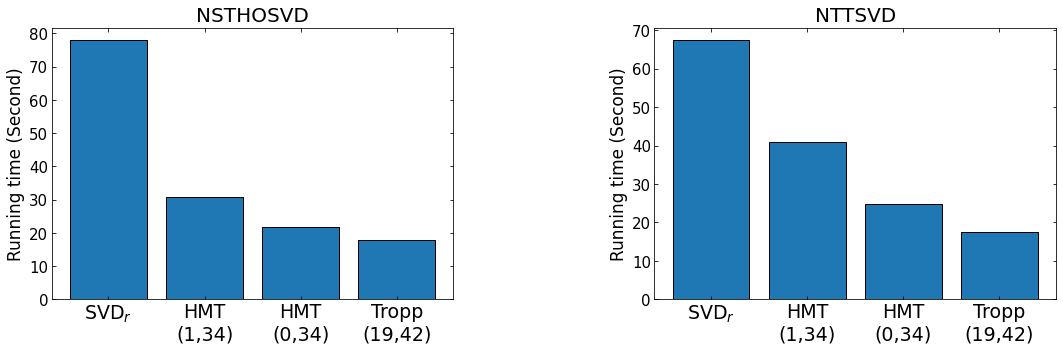

In [34]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True)

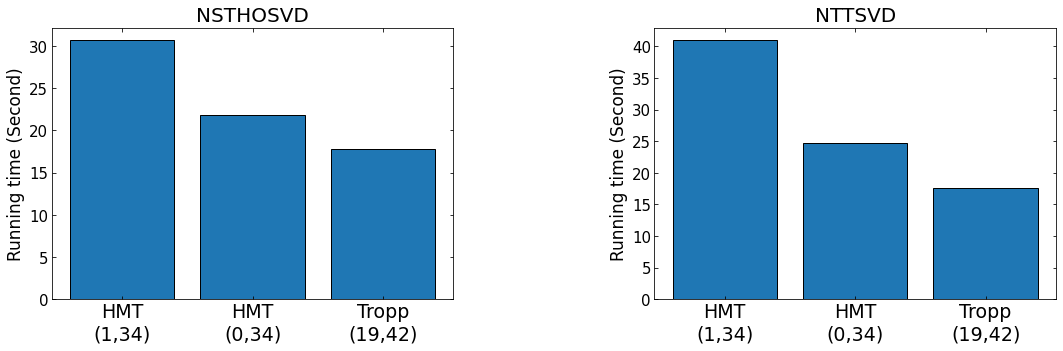

In [35]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

In [250]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  |  86.55 s.
HMT(1,34), Rad           |  47.03 s.
HMT(0,34), Rad           |  38.85 s.
Tropp(19,42), Rad        |  29.78 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  | 106.05 s.
HMT(1,34), Rad           |  49.03 s.
HMT(0,34), Rad           |  39.92 s.
Tropp(19,42), Rad        |  28.84 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 444.38 s.
------------------------------------


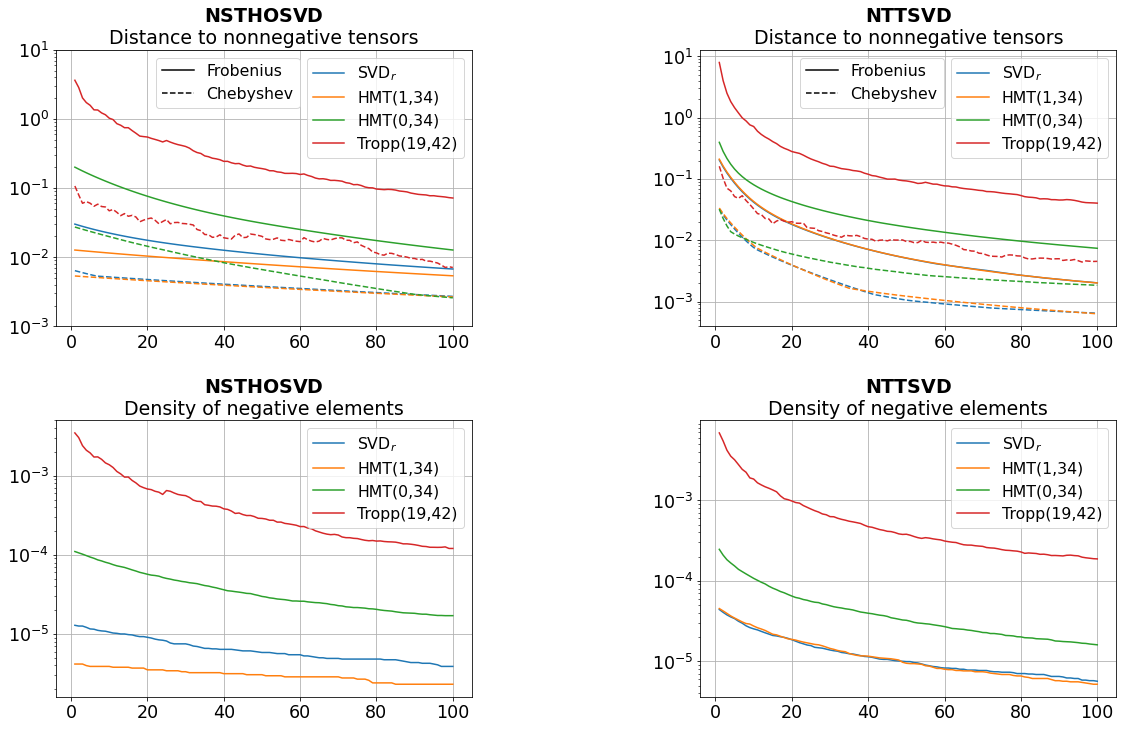

In [251]:
fig, ax = ex.plotConvergence3(figsize=(19, 11.9),
                              yticks=[10**(-x) for x in range(-1, 4)],
                              wspace=0.55,
                              hspace=0.34,
                              titlesize=19,
                              ticksize=17.5,
                              legendsize=15.74,
                              legendloc='upper right',
                              legend2loc=(0.24, 0.79))

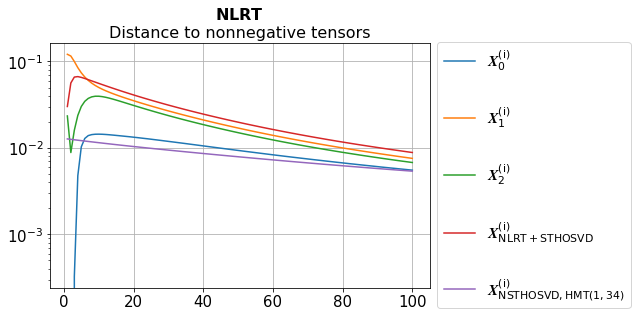

In [261]:
fig, ax = ex.plotConvergence(nttsvd=False,
                             nsthosvd=False,
                             nlrt=True,
                             figsize=(6.8, 4.5),
                             titlesize=16,
                             ticksize=15,
                             legendsize=15.5,
                             bbox_to_anchor=(1, 1.037), # bbox_to_anchor=(1, 1.038),
                             labelspacing=2.08, # labelspacing=1.74,
                             yticks=[10**(-x) for x in range(1, 4)])

In [253]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.082500234246253967 | 0.282574713230133057 | 10.83545 | 0.984317 |
| HMT(1,34), Rad           | 0.082575596858279976 | 0.276977236350392397 | 10.83148 | 0.984289 |
| HMT(0,34), Rad           | 0.097119222973940877 | 0.337449221944239763 | 10.12695 | 0.978267 |
| Tropp(19,42), Rad        | 0.143003478504668297 | 0.520384901266483180 |  8.44653 | 0.952881 |
------------------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.082973048090934753 | 0.263820350170135498 | 10.81063 | 0.984137 |
| HMT(1,34), Rad           | 0

In [254]:
ex.printNegativePart()

| NTTSVD                   | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.002024613553658127785 | 0.000649843248538672924 | 0.000564814814814814867 |
| HMT(1,34)                | 0.002020285919328606867 | 0.000634086408783192911 | 0.000518518518518518525 |
| HMT(0,34)                | 0.007425064413846669056 | 0.001849623837352679708 | 0.001601851851851851917 |
| Tropp(19,42)             | 0.040452532478553626660 | 0.004547413091061303612 | 0.018703703703703705025 |
----------------------------------------------------------------------------------------------------------
| NSTHOSVD                 | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.006754

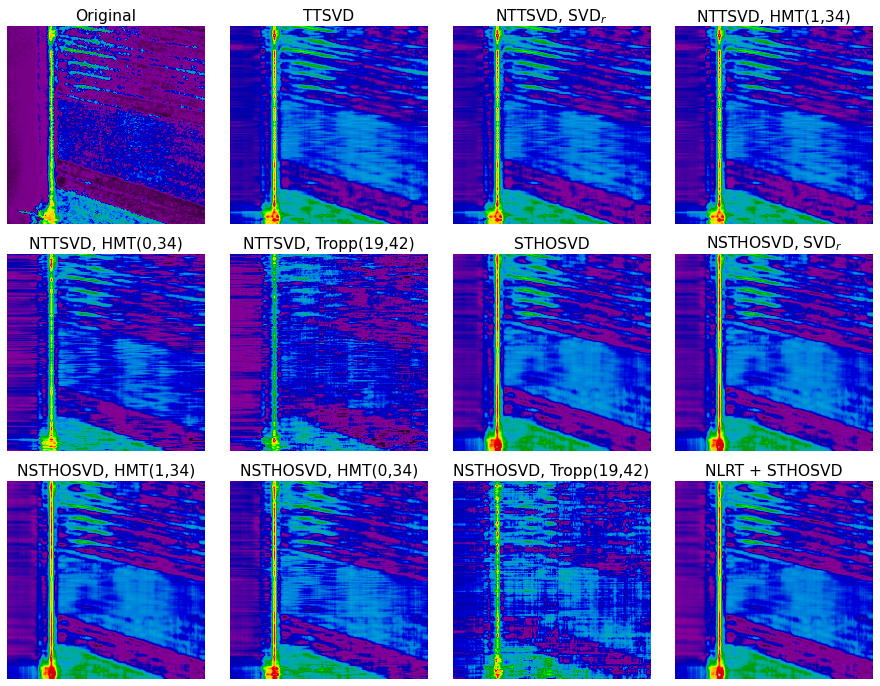

In [255]:
fig, ax = ex.showApproximations(band=100,
                                figsize=(15.6, 12),
                                ncols=4,
                                wspace=0.1,
                                hspace=0.15,
                                titlesize=15.5,
                                cmap='nipy_spectral')